## Import Libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# Parameters
data_path = "../"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"
out_dir = "./"

## Load MetaD Trajectory for ADP

In [3]:
backbone_selection_101 = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

# load data
prmtopFileName =  data_path + gro_file
trajFiles = [data_path+traj_file]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("selected atom indices:", sel_backbone_101.indices)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

['../run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr']
1
selected atom indices: [ 4  6  8 14 16]
Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms being analyzed: 5
Number of frames being analyzed: 100001


In [4]:
# load phi-psi data
time, phi, psi = np.loadtxt(data_path+colvar_file, usecols=(0,1,2), unpack=True)
print(phi.shape)

(100001,)


### run cluster scan on this data using uniform weights -->

In [5]:
cluster_array = np.arange(1,7,1).astype(int)
print("#clusters :", cluster_array)

#clusters : [1 2 3 4 5 6]


In [6]:
train, cv = scripts.cross_validate_cluster_scan\
(trajData, 50000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 50000
Number of frames to predict each model: 50001
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              29.446          16.942
              1               2               1              29.562          26.089
              1               2               2              29.529          25.859
              1               2               3              31.773          24.866
              1               2               4              30.259          24.919
              1               2               5              28.813          25.878
              1               2               6              29.315          24.809
              1               2               7              28.4

              2               6               2              52.538          83.550
              2               6               3              52.854         105.666
              2               6               4              52.733         116.711
              2               6               5              51.650         101.148
              2               6               6              53.237          61.744
              2               6               7              52.813          88.369
              2               6               8              51.241          75.730
              2               6               9              50.982          91.367
              2               6              10              34.830         120.146
              3               1               1              26.893          28.357
              3               2               1              35.695          39.625
              3               2               2              28.103         

              4               5               6              52.241          38.401
              4               5               7              52.369          28.037
              4               5               8              51.343          48.456
              4               5               9              49.071          52.392
              4               5              10              52.864          29.180
              4               6               1              52.667          58.617
              4               6               2              52.664          35.508
              4               6               3              51.044          40.619
              4               6               4              51.891          58.665
              4               6               5              33.019          60.284
              4               6               6              36.704          55.509
              4               6               7              53.118         

In [7]:
# write to data files
np.savetxt("train.dat", np.column_stack((cluster_array, train)))
np.savetxt("cv.dat", np.column_stack((cluster_array, cv)))

In [8]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

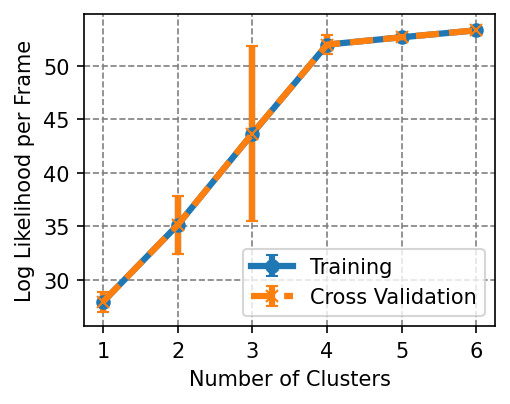

In [9]:
# create figure
plt.figure(figsize=(3.5,2.8), dpi= 150, facecolor='w', edgecolor='k')

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

plt.errorbar(cluster_array,train_mean, train_std, fmt='-o', lw=3, capsize=3, label="Training")

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

plt.errorbar(cluster_array, cv_mean, cv_std, fmt='--x', lw=3, capsize=3, label="Cross Validation")

plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame")
plt.xlabel("Number of Clusters")
plt.tick_params(axis='both')
plt.legend(loc="lower right")
plt.tight_layout()

## n_clusters = 2 

In [10]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 2, 40, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              28.621          51.690
       2              28.839          51.397
       3              28.668          50.033
       4              29.504          47.663
       5              29.123          54.638
       6              35.514          43.002
       7              41.592          40.768
       8              27.324          47.469
       9              28.205          53.971
      10              29.127          47.041
      11              28.549          48.836
      12              30.738          45.470
      13              33.658          44.621
      14              27.732          56.790
      15              27.067          52.533
      16              28.599          52.395
      17              32.921          46.761
      18              29.559          49.491
      19       

In [11]:
with open("wsgmm_2state_wout_weights_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [12]:
with open("wsgmm_2state_wout_weights_nattempts_40.pickle", "rb") as f:
    wsgmm2 = pickle.load(f)

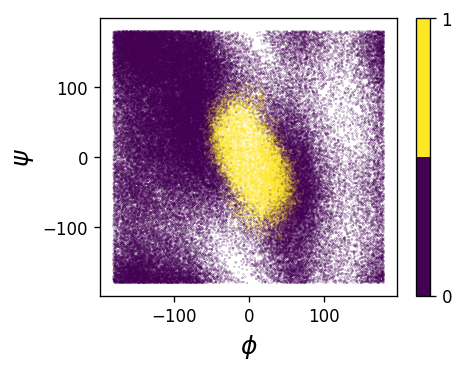

In [13]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm2.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm2.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 3

In [14]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 40, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              33.503          63.534
       2              33.368          56.906
       3              31.215          68.844
       4              31.714          59.147
       5              37.334          59.988
       6              29.836          63.266
       7              28.366          81.176
       8              29.882          68.749
       9              28.654          81.687
      10              33.065          59.640
      11              28.493          81.687
      12              27.494          76.100
      13              53.201          65.006
      14              33.513          59.087
      15              29.243          71.950
      16              29.158          80.310
      17              28.793          73.374
      18              30.598          68.487
      19       

In [15]:
with open("wsgmm_3state_wout_weights_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [16]:
with open("wsgmm_3state_wout_weights_nattempts_40.pickle", "rb") as f:
    wsgmm3 = pickle.load(f)

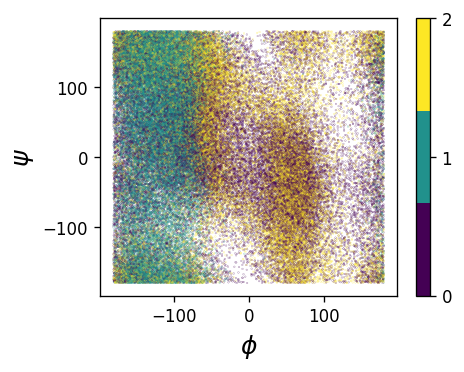

In [17]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm3.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 4

In [18]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 40, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              51.281          46.510
       2              29.829          91.149
       3              50.915          58.315
       4              35.511          82.038
       5              32.498          91.515
       6              53.490          71.339
       7              34.619          71.287
       8              53.055          72.957
       9              32.852          83.964
      10              30.301          83.719
      11              30.868          94.871
      12              52.243          62.526
      13              36.377          80.845
      14              30.715          78.611
      15              50.666          55.964
      16              30.231          89.774
      17              51.925          52.330
      18              29.241          94.950
      19       

In [19]:
with open("wsgmm_4state_wout_weights_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [20]:
with open("wsgmm_4state_wout_weights_nattempts_40.pickle", "rb") as f:
    wsgmm4 = pickle.load(f)

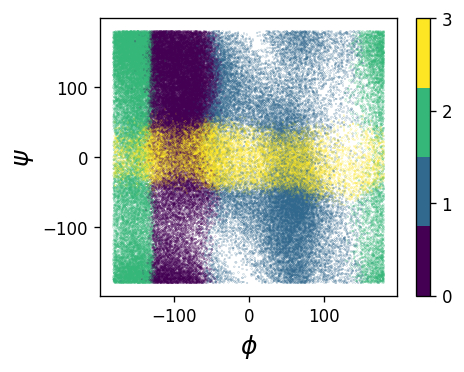

In [21]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm4.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)

## n_clusters = 5 

In [22]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 5, 40, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 5
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              35.154         104.479
       2              50.082         100.941
       3              50.793          70.930
       4              31.572         101.337
       5              50.005         100.737
       6              53.057          60.563
       7              50.877          69.107
       8              53.427         103.240
       9              33.305          99.160
      10              31.121         107.145
      11              34.073         109.581
      12              37.512          96.437
      13              29.946         110.465
      14              28.702         111.308
      15              52.216          91.285
      16              53.789         103.616
      17              52.344         108.293
      18              30.141         101.361
      19       

In [23]:
with open("wsgmm_5state_wout_weights_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [24]:
with open("wsgmm_5state_wout_weights_nattempts_40.pickle", "rb") as f:
    wsgmm5 = pickle.load(f)

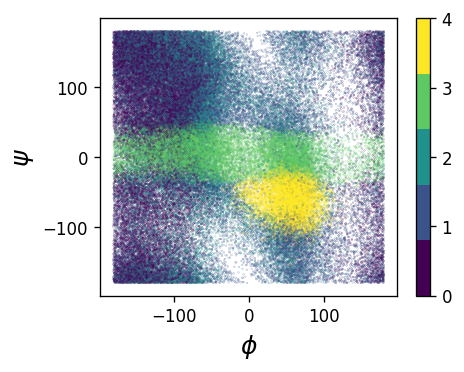

In [25]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm5.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)

## n_clusters = 6 

In [26]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 6, 40, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 6
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              46.655         104.373
       2              31.624         127.399
       3              52.773          95.262
       4              52.055          98.204
       5              52.951         118.620
       6              53.338          84.286
       7              53.623         101.428
       8              52.249          67.910
       9              32.042         108.711
      10                 nan          86.633
      11              51.107          79.185
      12              53.628          95.598
      13              33.245         113.098
      14              52.165          95.015
      15                 nan          18.325
      16              30.562         121.511
      17              53.396          88.785
      18              51.360         135.708
      19       

In [27]:
with open("wsgmm_6state_wout_weights_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [28]:
with open("wsgmm_6state_wout_weights_nattempts_40.pickle", "rb") as f:
    wsgmm6 = pickle.load(f)

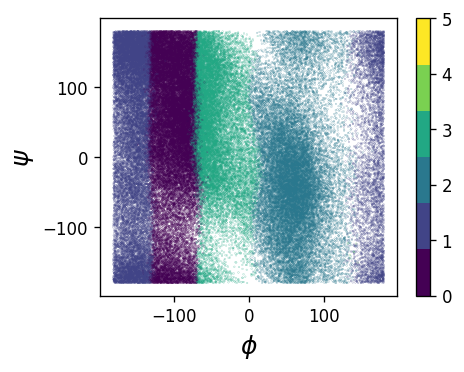

In [29]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm6.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm6.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)